## cta策略的研究报告
### ——基于ricequant平台数据及回测引擎的DEMO

cta策略研究是基于传统技术分析思想的一种研究方法，技术分析三大假设认为

因其风险分散可控的特征（多品种、多周期），与量化能有很好的结合，是期货、外汇等市场量化研究不可或缺的一个研究方向。

cta一般分为趋势型和反趋势型两大类策略，本报告基于个人见解和同行的交流、专家教导，给出一种日内反趋势型策略的研究过程，望能获得充分批评，继续改进策略研究过程和效率。

### 策略研究流程

作为量化的初学者，我认为cta量化研究的过程可以分为下面几个步骤：

1、准备数据，建立数据库————————自建、第三方（wind、ts等来源）

        |
        V
2、开发回测引擎————————————自建、第三方（安全性、灵活性以及效率）

        |
        V
3、策略雏形、框架、想法————————来源于经验、交流、书籍论文等

        |
        V
4、准备样本——————————————需要验证的行情数据，分为回测样本、验证样本

        |
        V
5、确定策略总体思路和模型框架—————确定模型、参数、品种、周期等，进行初步统计检验

        |
        V
6、基于回测引擎开发单个策略——————交易报单、日志与行情比对，需要反复确认买卖逻辑等是否符合策略思想、交易规则
        
        |
        V
7、在回测样本上回测、训练参数—————确认需要训练的参数、步长等
        
        |
        V
8、分析回测结果————————————绩效指标（sharpe、maxdrawdown等）以及参数的分析、统计检验，避免过拟合
        
        |
        V
9、回测验证样本————————————分析策略的可行性，若有过拟合的犹豫，重复7-9，或者回到3、4，改进策略逻辑，测试其他品种等。
        
        |
        V
10、基于研究的模拟交易，进行一段时间观察————模拟交易环境要与实盘交易环境一致
        
        |
        V
11、重复3-10，研究、开发一系列策略、推送实盘（如何做投资组合可以展开为其他量化思路了）

关于引擎、系统开发，个人对这一块不太熟，研究报告基于ricequant平台去进行步骤3-9的研究。

### 策略想法
我们知道波动率是非常重要的指标，在行情研究上需要通过历史波动率去推断实际或未来的波动率，期权交易就是围绕如何预测未来波动率进行交易。

波动率函数有很多种计算方法，比如常用的收益率标准差除以样本数平方根，均价的标准差区间如布林带指标，基于最高价减去最低价构成的range如经典的ATR指标等。

在期货市场里，简单的range也有很好的效果，不少经典交易策略都是基于一定周期内的range进行突破交易或反转交易。

如dual trust策略即是根据range的突破策略，下面给出一种基于range的反转策略研究思路。

期货市场例，螺纹钢的交易量较大，因此波动率应该不差，适合作为例子进行研究。

首先，考察螺纹钢的交易规则，螺纹钢在14年12月26日才开始出夜盘，而在16年5月3日则把夜盘改为2小时。

也就是说，螺纹钢交易时间段的不同，可能会让螺纹钢的range大小发生变化，而其日内波动的特征也可能不同。

In [16]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [2]:
df1 = get_price('RB88', start_date = "2013-05-01", end_date = "2018-05-01", frequency = '1d', fields = ['high', 'low'])
df2 = get_price('RB88', start_date = "2013-05-01", end_date = "2014-12-25", frequency = '15m', fields = ['high', 'low'])
df3 = get_price('RB88', start_date = "2014-12-26", end_date = "2016-05-01", frequency = '15m', fields = ['high', 'low'])
df4 = get_price('RB88', start_date = "2016-05-01", end_date = "2018-05-01", frequency = '15m', fields = ['high', 'low'])

In [3]:
df1['range'] = df1['high'] - df1['low']
df2['range'] = df2['high'] - df2['low']
df3['range'] = df3['high'] - df3['low']
df4['range'] = df4['high'] - df4['low']

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


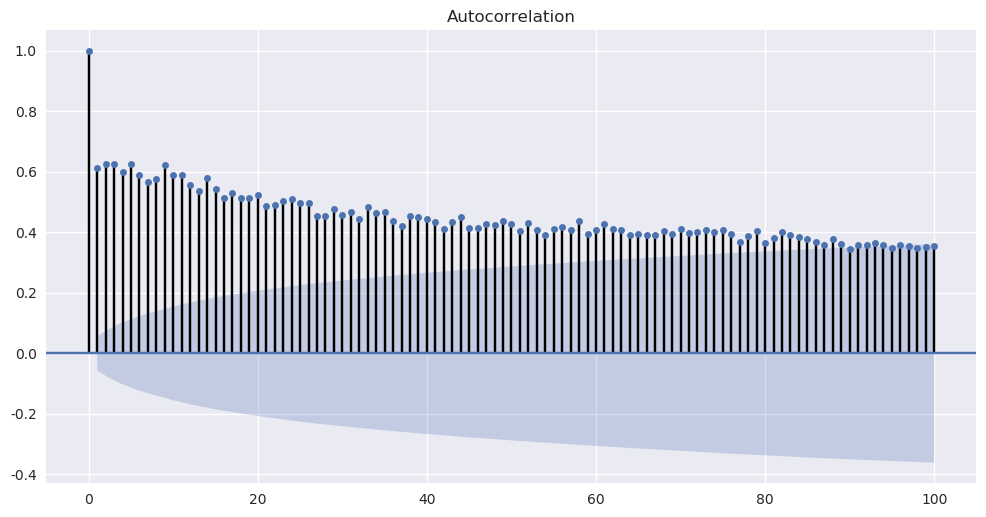

In [4]:
plot_acf(df1['range'], lags = 100)
plt.show()

上图是螺纹钢主力合约日线range的自相关性，可以看出其自相关性从0.6开始逐步下降至lags100的0.4，这在行情数据里算是很不错的自相关性。

如果我们猜测range具有一定的记忆效应，那么每一天的range都可以由前面几天的range来推断。

因此，我们策略的初步构思是，以range作为函数，k作为参数构建一个策略。我们期望range在一个范围内波动，因此策略的初步条件是：

##### price < open - k * range，则做多

##### price > open + k * range，则做空。

与dual trust策略刚好相反，这个策略是属于日内反转，而非日内突破。

### 准备样本

在初步测试里，我发现用日线来回测的结果非常不好，原因估计是交易规则的问题。

与国外外汇市场等有连续交易时段的市场不同，国内期货如螺纹钢的交易时段分为三段，而上午还有15分钟的休息时间，因此行情跳空和range的滞后性可能会让策略效果大打折扣。

日线策略的详情，这里就不展示了。

因此，产生了第二个想法，用分钟周期的bar来建立range。

螺纹钢的交易时段是早盘135分钟，午盘90分钟，夜盘120分钟（16年5月之前是240分钟），其最大公约数是15，因此这里取用15m的bar作为检验。

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


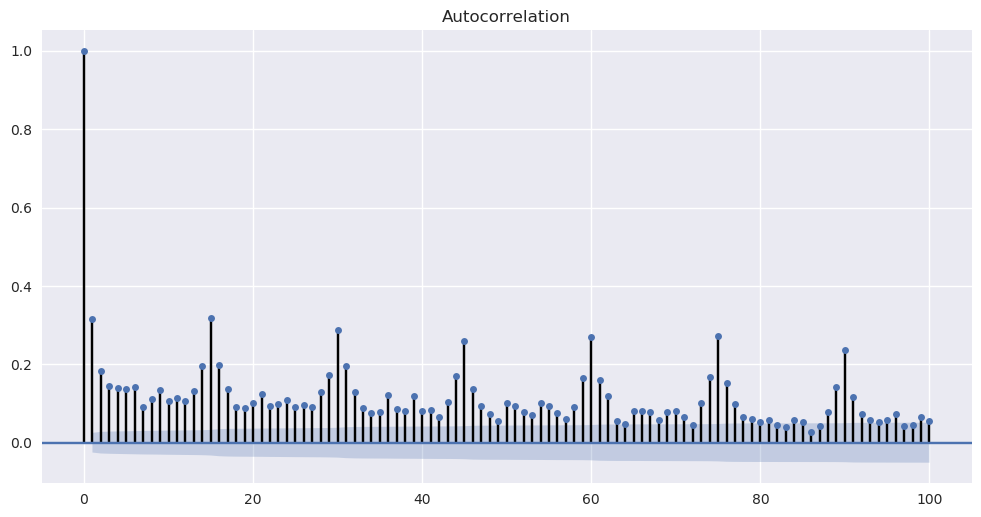

In [5]:
plot_acf(df2['range'], lags = 100)
plt.show()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


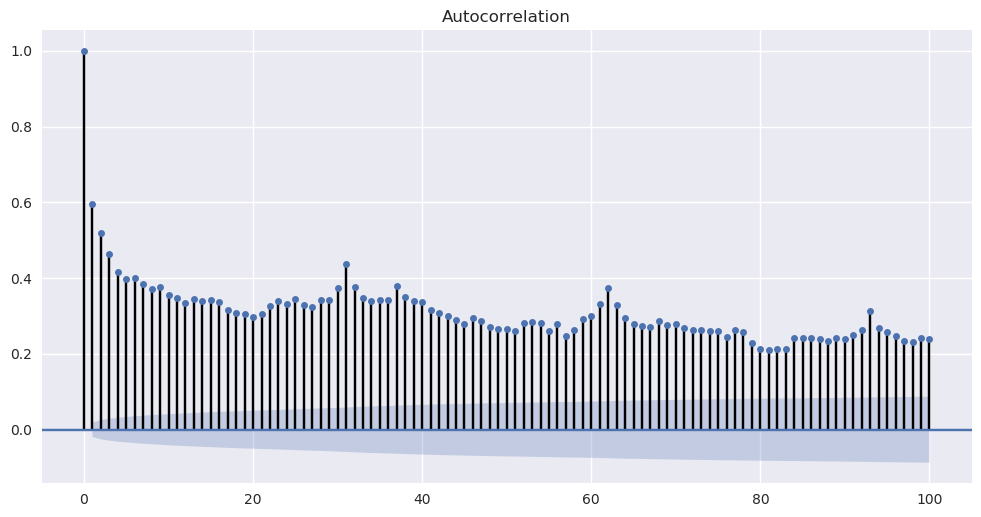

In [6]:
plot_acf(df3['range'], lags = 100)
plt.show()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


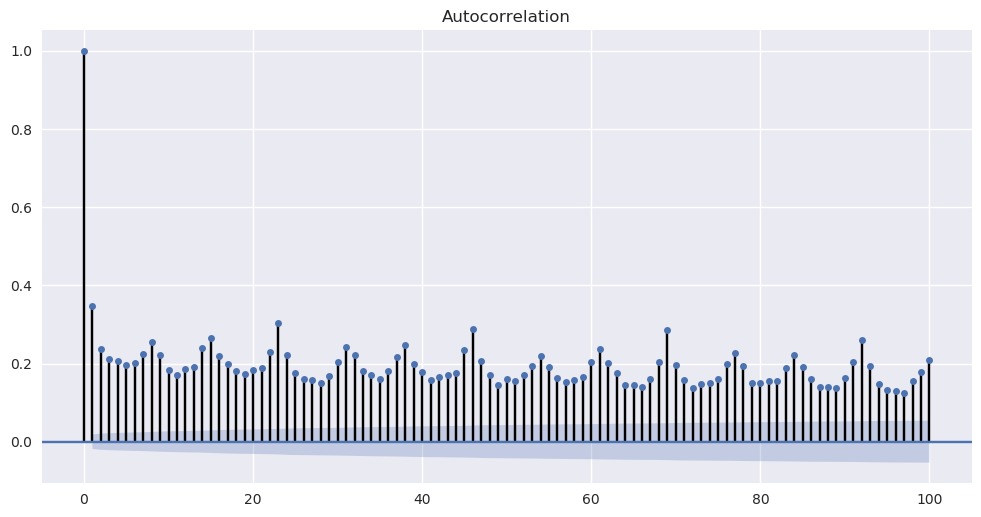

In [7]:
plot_acf(df4['range'], lags = 100)
plt.show()

上面三图分别是螺纹钢近5年，没有夜盘时期、夜盘4小时和夜盘2小时的15分钟range的自相关性。

可以发现第一个图的周期性很强，以15个bar的周期作为跳动，而15个bar的周期刚好是一天的交易时长，不过在其他lags上的自相关性较差。

第二个图，每天交易时长31个bar的周期性也很强，不过其他lags上的自相关性也不差，周期波动规律性不算明显。

第三个图，每天交易时长23个bar的周期性很强，而且早午晚盘周期数的自相关性波动，比第二个图明显。

我推测，螺纹钢在夜盘四小时时期的规律与目前夜盘两小时时期的规律，可能并不相同。

因此无法利用16年5月之前的行情数据，去训练我们的日内模型，交易规则常变，这也算是国内期货的一个难点。

由于只有两年的行情对我们有用，最好把16年5月至17年4月的行情作为回测或训练样本，17年5月至18年4月的行情作为验证或测试样本。

### 确定策略总体思路和模型框架

上面已经观察以23为一个周期的规律，因此我们可以每15分钟，以23的倍数个bar构建range,即

##### range = hhv(23n) - llv(23n)

下面来看看n取1、2、3时，range的分布情况

In [8]:
df5 = get_price('RB88', start_date = "2016-05-01", end_date = "2017-04-28", frequency = '15m', fields = ['high', 'low'])

In [9]:
df5 = df5.reset_index()

In [10]:
k = 23
range_list1 = []
for index, row in df5.iloc[k:].iterrows():
    time = row['index'].time()
    if ((time.minute)%15) == 0:
        last_max = df4.iloc[index - k:index]['high'].max()
        last_min = df4.iloc[index - k:index]['low'].min()
        range_list1.append(last_max - last_min)

In [11]:
k = 23 * 2
range_list2 = []
for index, row in df5.iloc[k:].iterrows():
    time = row['index'].time()
    if ((time.minute)%15) == 0:
        last_max = df5.iloc[index - k:index]['high'].max()
        last_min = df5.iloc[index - k:index]['low'].min()
        range_list2.append(last_max - last_min)

In [12]:
k = 23 * 3
range_list3 = []
for index, row in df5.iloc[k:].iterrows():
    time = row['index'].time()
    if ((time.minute)%15) == 0:
        last_max = df5.iloc[index - k:index]['high'].max()
        last_min = df5.iloc[index - k:index]['low'].min()
        range_list3.append(last_max - last_min)

In [13]:
df_range1 = pd.DataFrame(range_list1, columns = ['range'])
df_range2 = pd.DataFrame(range_list2, columns = ['range'])
df_range3 = pd.DataFrame(range_list3, columns = ['range'])

In [14]:
df_range1.describe()

,range
count,5487.000000
mean,102.613632
std,53.401882
min,28.000000
25%,66.000000
50%,91.000000
75%,125.000000
max,379.000000


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


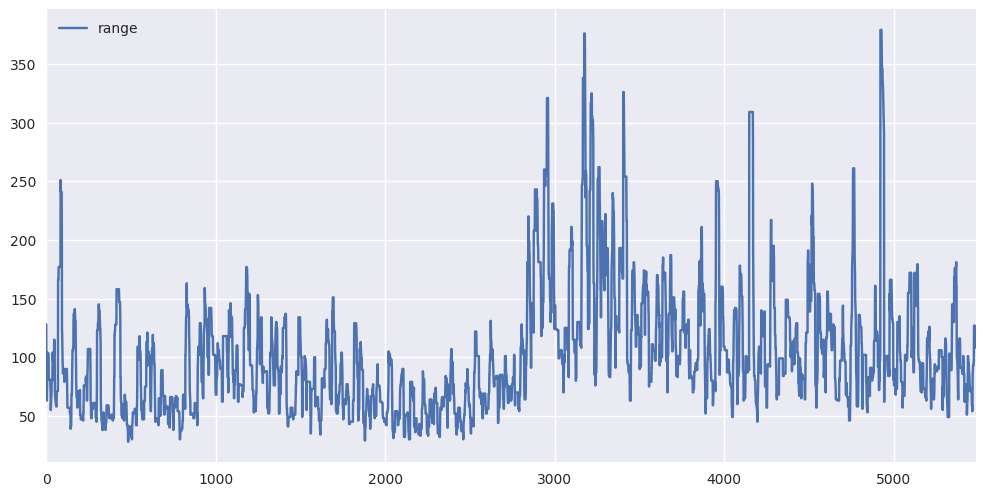

In [15]:
df_range1.plot()

In [17]:
df_range2.describe()

,range
count,5464.000000
mean,149.254209
std,71.630208
min,41.000000
25%,100.000000
50%,131.000000
75%,177.000000
max,475.000000


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


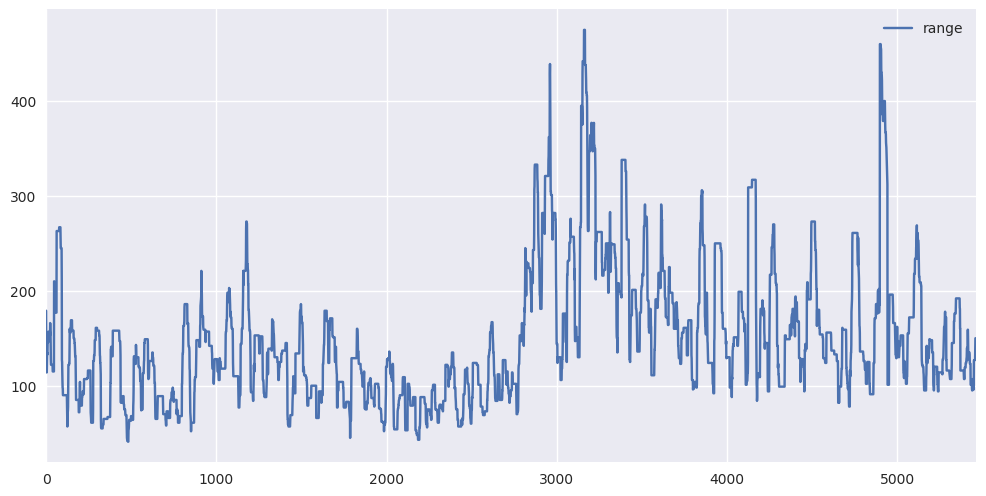

In [18]:
df_range2.plot()

In [19]:
df_range3.describe()

,range
count,5441.000000
mean,185.845065
std,84.357880
min,63.000000
25%,128.000000
50%,164.000000
75%,224.000000
max,524.000000


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


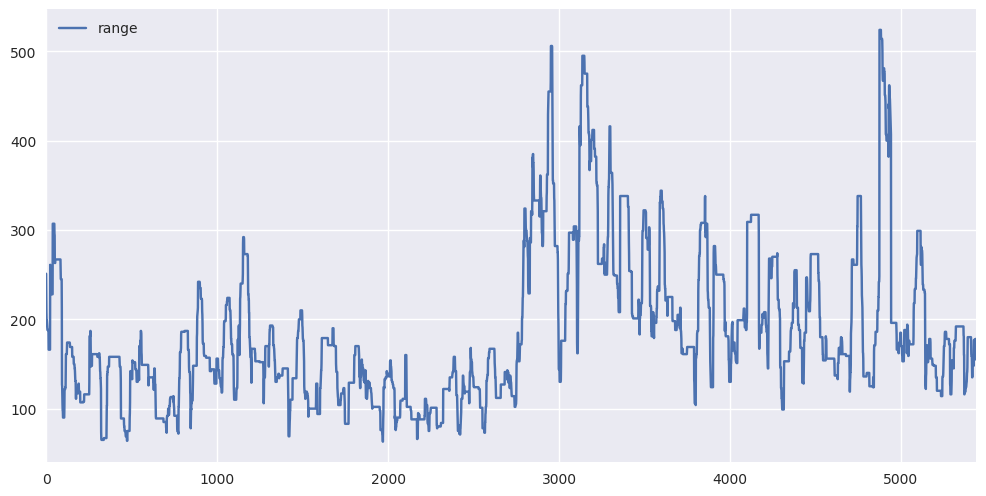

In [20]:
df_range3.plot()

上面分别是n = 1、2、3时，range的统计描述和序列，range本身并不是一个平稳序列，来看看其一阶差分如何。

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


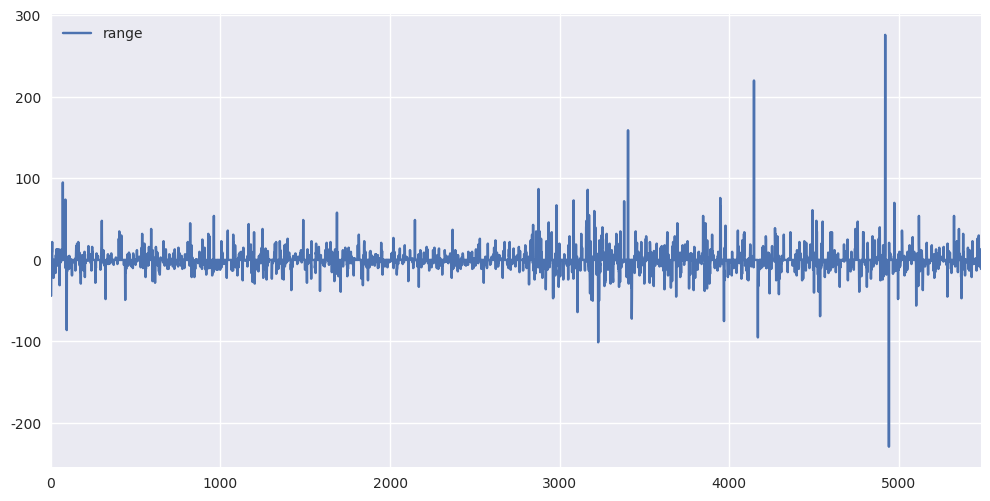

In [21]:
df_range1.diff(1).plot()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


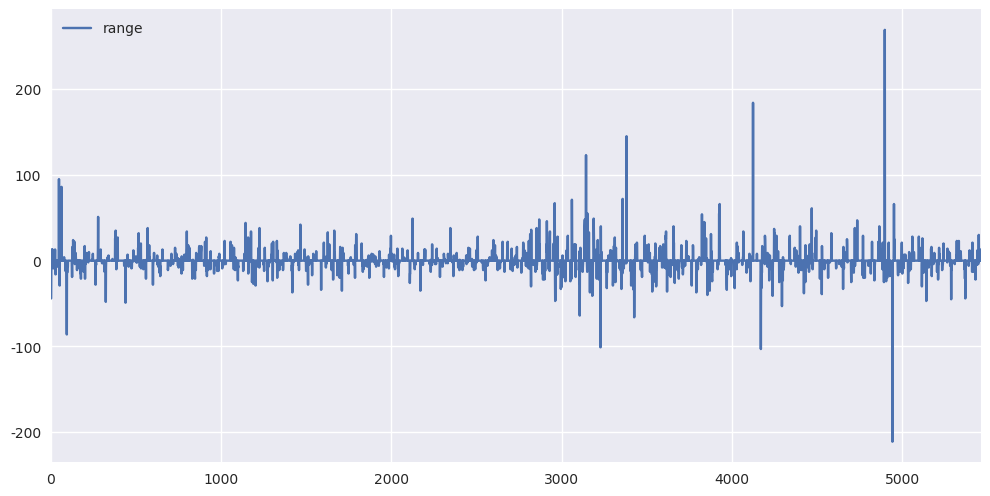

In [22]:
df_range2.diff(1).plot()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


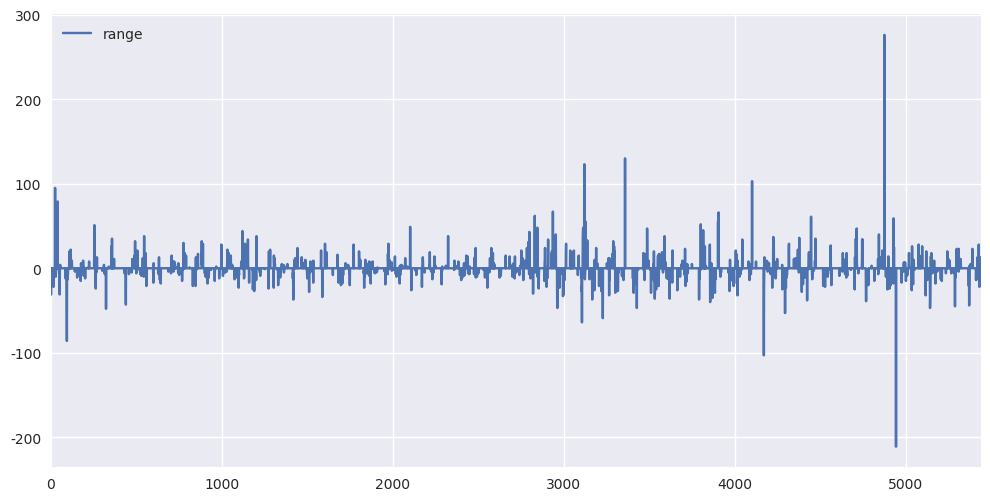

In [23]:
df_range3.diff(1).plot()

In [28]:
adfuller(df_range1.diff(1)['range'].tolist()[1:])

(-24.227568129141147,
 0.0,
 22,
 5463,
 {'1%': -3.4315475792297763,
  '10%': -2.5670516976361606,
  '5%': -2.8620692103923964},
 41621.465592761342)

In [29]:
adfuller(df_range2.diff(1)['range'].tolist()[1:])

(-15.354375351158511,
 3.6836067790500493e-28,
 30,
 5432,
 {'1%': -3.431554416954754,
  '10%': -2.567053305802792,
  '5%': -2.8620722313718825},
 40434.60708029849)

In [27]:
adfuller(df_range3.diff(1)['range'].tolist()[1:])

(-17.644460329063371,
 3.7454700405774476e-30,
 14,
 5425,
 {'1%': -3.4315559717774264,
  '10%': -2.5670536714816623,
  '5%': -2.8620729183080771},
 39242.032117582166)

通过adf检验，可见三者的一阶差分都是较为平稳序列，因此range确实有一定可预测的范围在，不过几个偏差值令人担心。

再来看看range的分布情况

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


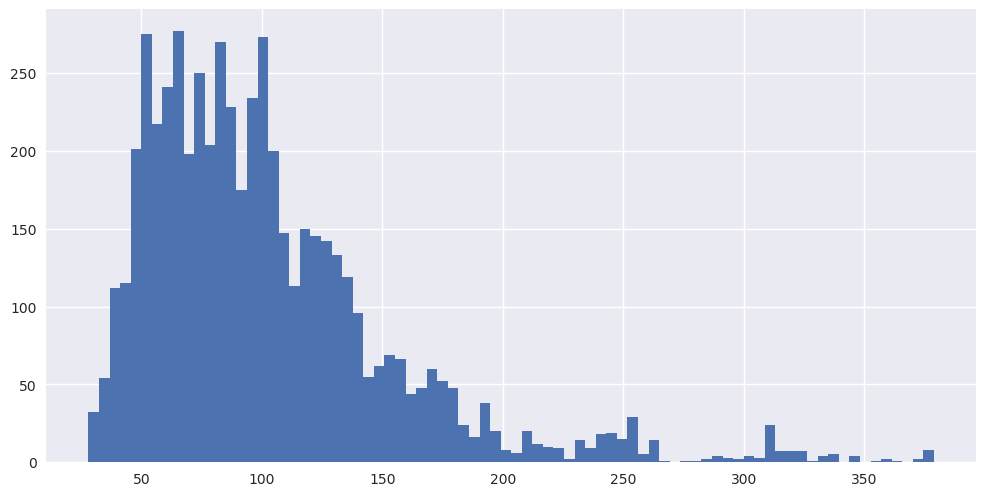

In [30]:
plt.hist(df_range1['range'], bins=80)
plt.show()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


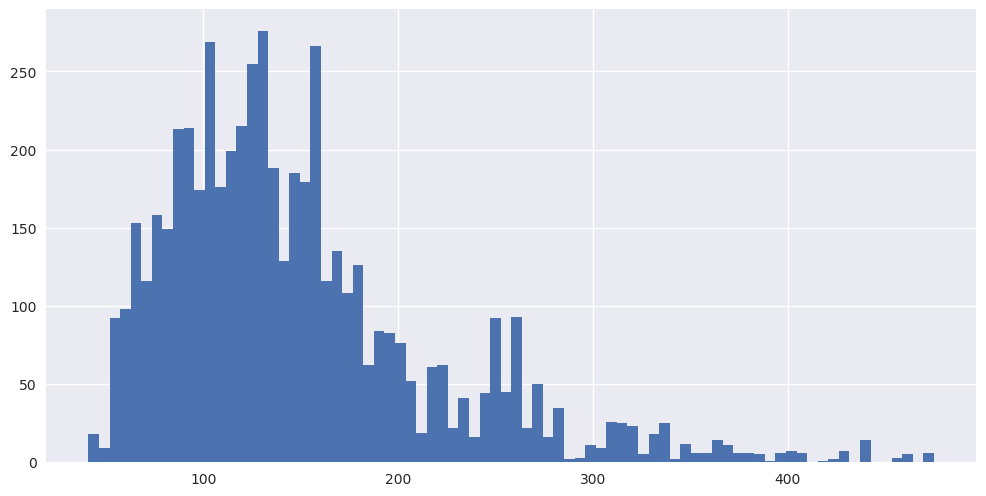

In [31]:
plt.hist(df_range2['range'], bins=80)
plt.show()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


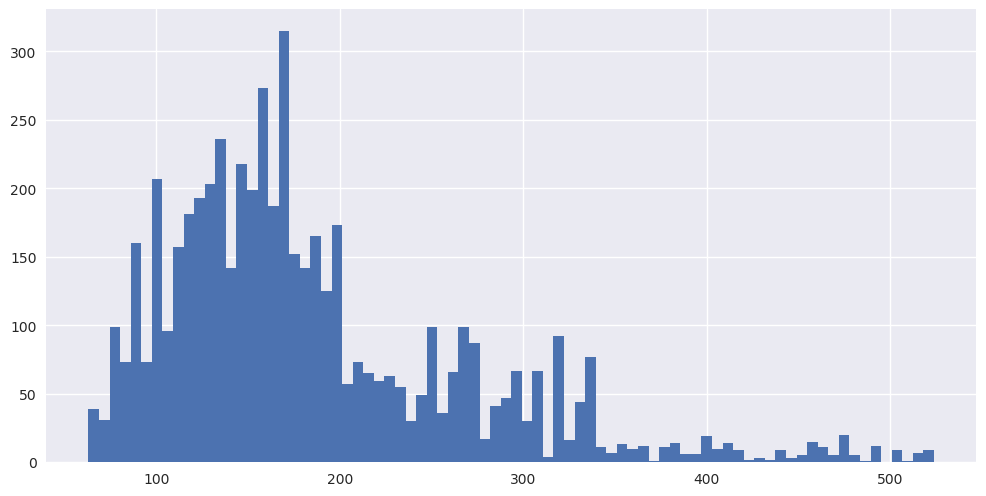

In [32]:
plt.hist(df_range3['range'], bins=80)
plt.show()

由上图发现，range是一个偏态分布，右边带有长尾。

根据一定的个人经验，如果行情在日内突破某个高点，会很快地打到涨停板，这样的趋势行情很大可能会延续到第二天，对我们的反转策略非常不利。

因此我认为有必要对range固定在一个合理的范围。把range取对数再看看其分布。

In [33]:
ln1 = []
for i in range_list1:
    ln1.append(np.log10(i))
l = np.array(ln1)
mean = np.mean(l)
std = np.std(l)
print(stats.kstest(l, 'norm', (mean, std)))
lower, upper = stats.t.interval(0.9,len(ln1)-1, mean, std)
print(lower, upper)
print(10 ** lower, 10 ** upper)

KstestResult(statistic=0.026474912900004588, pvalue=0.00091301338511875292)
1.62841949089 2.29567868381
42.5029907848 197.550750451


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


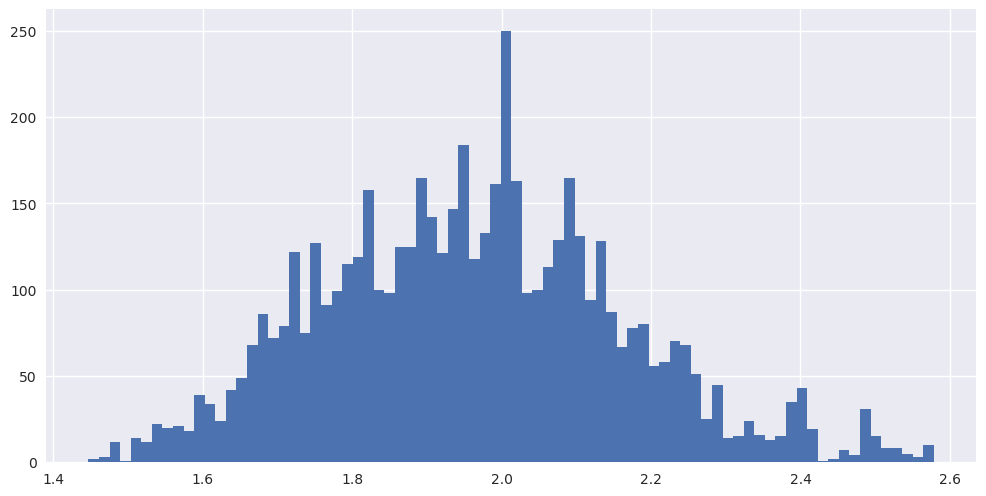

In [34]:
plt.hist(ln1, bins = 80)
plt.show()

In [35]:
ln2 = []
for i in range_list2:
    ln2.append(np.log10(i))
l = np.array(ln2)
mean = np.mean(l)
std = np.std(l)
print(stats.kstest(l, 'norm', (mean, std)))
lower, upper = stats.t.interval(0.9,len(ln2)-1, mean, std)
print(lower, upper)
print(10 ** lower, 10 ** upper)

KstestResult(statistic=0.036450423469998716, pvalue=9.8940874521704909e-07)
1.81123556755 2.44835134
64.7493730388 280.770412465


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


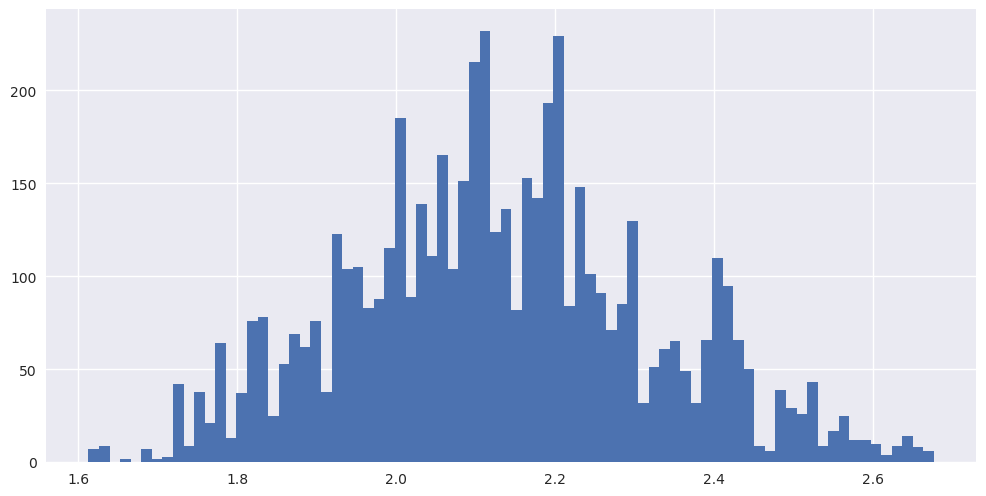

In [37]:
plt.hist(ln2, bins = 80)
plt.show()

In [38]:
ln3 = []
for i in range_list3:
    ln3.append(np.log10(i))
l = np.array(ln3)
mean = np.mean(l)
std = np.std(l)
print(stats.kstest(l, 'norm', (mean, std)))
lower, upper = stats.t.interval(0.9,len(ln3)-1, mean, std)
print(lower, upper)
print(10 ** lower, 10 ** upper)

KstestResult(statistic=0.05544611261140675, pvalue=5.9162462016864865e-15)
1.92968048754 2.52970353886
85.0512082301 338.612930897


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


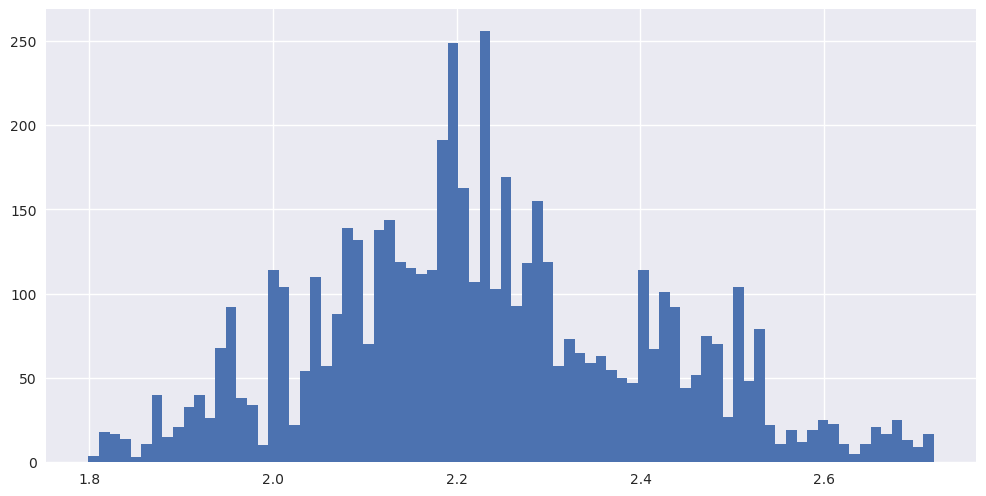

In [39]:
plt.hist(ln3, bins = 80)
plt.show()

由图观察和p值，可见range的对数是一个t分布。

因此我取其上下5%的范围内作为置信区间，如果range落在置信区间范围内，则进行交易，否则pass。

#### condition = CI_lower <= range <= CI_upper

在置信区间条件range可取的n倍数，可以和开仓条件range一样大或不同，个人的一点经验是可以大一到两个n。

不过n取太大的话，range的自相关会衰减，可能会有影响，各种组合需要更多测试。

后面的回测分别取

range1 = hhv(23) - llv(23)，range2 = hhv(46) - llv(46)，range3 = hhv(69) - llv(69)

当以price <= open - k * range1作为开仓条件时，其置信条件取 64 <= range2 <= 277

当以price <= open - k * range2作为开仓条件时，其置信条件取 85 <= range3 <= 334

（回测取的的置信区间与上面计算有一点点差异，不过不影响）

### 基于回测引擎开发单个策略

基于回测平台的工作，需要不断躲过各种bug和坑，添加上符合交易规则的条件，下面会详解。

### 在回测样本上回测、训练参数

有了策略框架，我们就可以来训练参数了。

首先，最重要的参数当然是range的k值，如有计算能力强的引擎，最好以区间步长为np.arange(0.02,1.01,0.02)。

因为ricequant性能限制略过了一点步骤，太大的k值经早期测试并没有很好的结果，下面的回测以[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]为例

此外，还需要确定其他可训练的参数，不过不宜太多，否则策略对参数过于敏感，robust和泛化能力就很差，一旦市场环境有变，就很容易失效了。

我在这里取了2个，分别是止损和止盈的参数。

止损止盈可以取固定值，不过在交易经验不丰富时，最好寻找一下区间，在此策略里，以range作为止损止盈的函数。

以做多为例

##### price <= buy_price - range * stop_lose_k，则止损

##### price >= buy_price + range * take_profit_k，则止盈

为了简化，下面的stop_lose_k参数取[0.05, 0.15, 0.25, 0.35, 0.45]，take_profit_k参数取[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

这样，我们得到了6 \* 5 \* 8的回测矩阵，把参数矩阵导入策略中进行训练。

此外，我认为在国内期货市场里，上涨的逻辑和下跌的逻辑是不同的，并没有很好的对称性，因此我认为做多策略和做空策略应该分开训练。

下面是ricequant上的源代码，以做多策略为例

``` python
import os
from rqalpha_plus import run_func
from rqalpha_plus.api import *

import pandas as pd
# 防止溢出
import sys
sys.setrecursionlimit(10**8) 

# 回测引擎的配置
# 以10w资金每次只做一手
config = {
  "base": {
    "start_date": "2016-05-02", #回测开始日期
    "end_date": "2017-04-28", #回测结束日期
    "frequency": '1m', #handle_bar周期
    "margin_multiplier": 1, #保证金倍率
    "accounts": {
        "future": 100000
    }
    
  },
  "extra": {
    "log_level": "info",
  },
  "mod": {
    "sys_progress": {
        "enabled": True,
        "show": True,
    },
    "sys_analyser": {
        "enabled": True,
    },
    "sys_simulation": {
    "matching_type": "current_bar", #当前bar收盘价交易
    "commission_multiplier": 1, #佣金倍率
    "slippage": 0, #滑点水平，ricequant的滑点按百分比计算，如有需要在回测后的total_value手动加上
    }
  }
}
```

``` python
# 添加任务

tasks = []
# 6 * 5 * 8的参数矩阵，一共240次回测
# 用np.arange的格式在dict里显示会有问题，这里用了range
for range_k in range(5, 35, 5): 
    for k_sl in range(5, 55, 10):
        for k_tp in range(20, 100, 10): 
            tasks.append((config, range_k/100, k_sl/100, k_tp/100))
```

``` python
### ricequant的回测策略主体

def run_bt(config, range_k, k_sl, k_tp):
    # 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
    import datetime

    def init(context):
        # context内引入全局变量
        #context.benchmark = "RB88"
        # 注意回测开始日的主力合约
        context.now_contract = "RB1610"
        # 是否发出了报单指令
        context.fired_buy = False


        # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新。
        subscribe(context.now_contract)
        # 实时打印日志
        logger.info("RunInfo: {}".format(context.run_info))

        # 今天涨停价，跌停价
        context.today_limit_up = 0.0
        context.today_limit_down = 0.0

        # 当前bar信息和前一bar信息，用于处理买卖逻辑
        context.l_open = 0.0
        context.l_high = 0.0
        context.l_low = 0.0 
        context.l_close = 0.0
        context.c_open = 0.0
        context.c_high = 0.0
        context.c_low = 0.0
        context.c_close = 0.0

        # 长短时间的区间，range选择345分钟的倍数
        context.range1 = 0.0
        context.range2 = 0.0
        context.bar_period = 23 * 2
        # 波动条件
        # context.condition = (limit_min <= range*) and (range* <= limit_max)
        context.limit_min = 64
        context.limit_max = 277
        context.condition = False

        # 止损止盈参数，这里用range1确定
        # context.stop_loss = context.range1 * context.k_sl
        # context.take_profit = context.range1 * context.k_tp
        context.stop_loss = 0.0
        context.take_profit = 0.0
        # 参数可调，优先度最低
        context.k_sl = k_sl
        context.k_tp = k_tp

        # range1参数
        # 参数可调，优先度最高，步长最好是np.arange(0.02, 1.02, 0.02)
        # short_limit = context.c_open + context.range_k * context.range1
        # long_limit = context.c_open - context.range_k * context.range1
        context.range_k = range_k

        # 做多
        context.long_limit = 0.0

        # 手数
        context.lots = 1
        

    # before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
    def before_trading(context):
        # 每日初始化
        context.fired_buy = False

        # 处理换约
        dominant_contract = {
            '20160314': 'RB1610',
            '20160818': 'RB1701',
            '20161128': 'RB1705',
            '20170323': 'RB1710',
            '20170809': 'RB1801',
            '20171110': 'RB1805',
            '20180328': 'RB1810'
        }
        date = context.now.date().strftime('%Y%m%d')
        for d in dominant_contract:
            if date == d:
                unsubscribe(context.now_contract)
                context.now_contract = dominant_contract[d]
                subscribe(context.now_contract)


    # 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
    def handle_bar(context, bar_dict):
        # 当前bar时间
        now = context.now.time()

        # 前两根bar的ohlc
        context.l_open, context.l_high, context.l_low, context.l_close =\
        context.c_open, context.c_high, context.c_low, context.c_close
        
        current_bar = bar_dict[context.now_contract]
        context.c_open = current_bar.open
        context.c_high = current_bar.high
        context.c_low = current_bar.low
        context.c_close = current_bar.close
        # 检查是否有持仓
        buy_lots = context.future_account.positions[context.now_contract].buy_quantity
        #############################################################################
        # 早午晚盘开盘前的处理
        if (now == datetime.time(9,1,0,0)) or (now == datetime.time(13,31,0,0)) or (now == datetime.time(21,1,0,0)):
            # 获取涨停价，跌停价
            df = history_bars(order_book_id = context.now_contract, bar_count = 1, 
                            frequency = '1d', fields = ['limit_up', 'limit_down'], include_now = True)
            context.today_limit_up, context.today_limit_down = df[0]
            # 初始化，早午晚盘最多一单
            if buy_lots == 0:
                context.fired_buy = False
        #############################################################################
        # 每15分钟更新一次range1，计算开仓位置和止盈止损，可忽略假期没有夜盘的情况
        if ((now.minute - 1)%15) == 0:
            df = history_bars(order_book_id = context.now_contract, bar_count = context.bar_period, 
                            frequency = '15m', fields = ['high', 'low'], include_now = False)

            context.range1 = df['high'][23-context.bar_period:].max() - df['low'][23-context.bar_period:].min()
            context.range2 = df['high'].max() - df['low'].min()
            # 波动条件
            context.condition = (context.limit_min <= context.range2) and (context.range2 <= context.limit_max)

            # 开仓下限
            context.long_limit = context.c_open - context.range_k * context.range1
            # 止盈止损
            context.stop_loss = context.range1 * context.k_sl
            context.take_profit = context.range1 * context.k_tp
        #############################################################################
        # 如果接近跌停价，则不发单
        #if context.c_low <= context.today_limit_down * 1.005:
        #    context.fired_buy = True
        #############################################################################
        # 如果没有发过单，合乎开仓条件，则发单
        # 早午晚收盘前1分钟不发单
        if not context.fired_buy and context.condition and\
            not (now == datetime.time(11,30,0) or now == datetime.time(15,0,0) or now == datetime.time(23,0,0)):
            # 入场穿越逻辑
            if context.l_low > context.long_limit and context.c_low <= context.long_limit: 
                buy_open(id_or_ins = context.now_contract, amount = context.lots)
                context.fired_buy = True
        #############################################################################
        # 如果已有多头仓位     
        if buy_lots != 0:
            # 获取开仓均价
            buy_avg_price = context.future_account.positions[context.now_contract].buy_avg_holding_price

            # 止损止盈，考虑涨跌停版
            buy_sl = max((buy_avg_price - context.stop_loss), context.today_limit_down) 
            buy_tp = min((buy_avg_price + context.take_profit), context.today_limit_up)

            # 止损止盈
            if context.c_low <= buy_sl: 
                sell_close(id_or_ins = context.now_contract, amount = buy_lots)
            if context.c_high >= buy_tp:
                sell_close(id_or_ins = context.now_contract, amount = buy_lots)

        #############################################################################
        # 收盘前和星期五晚清理所有持仓
        if (now == datetime.time(14,59,0)) or (context.now.strftime('%w') == '5' and now == datetime.time(22,59,0)):
            if get_open_orders() != []:
                for order in get_open_orders():
                    cancel_order(order)

            # 收盘前市价平仓
            if buy_lots != 0:
                sell_close(id_or_ins = context.now_contract, amount = buy_lots)
                context.fired_buy = False


    # after_trading函数会在每天交易结束后被调用，当天只会被调用一次
    def after_trading(context):
        pass
      
    result = run_func(init=init, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)
    return result, range_k, k_sl, k_tp
```

``` python
### 获得回测结果

def run_tasks(tasks):
    import time
    time_start=time.time()
    results = []
    summaries = []
    
    i = 0
    for task in tasks:
        i += 1
        print('task {} running'.format(i))
        print('para: range_k={}-k_sl={}-k_tp={}'.format(task[1], task[2], task[3]))
        result = run_bt(*task)
        
        results.append({'range_k={}-k_sl={}-k_tp={}'.format(result[1], result[2], result[3]) : result[0]})
        df = result[0]['sys_analyser']['trades']
        wins = 0
        for j in range(0, len(df), 2):
            if (df.ix[j+1]['last_price'] - df.ix[j]['last_price']) > 0:
               wins = wins + 1
        win_rate = round(2 * wins/len(df), 3)
        
        summaries.append({'_para_range_k': result[1],
                          '_para_k_sl': result[2],
                          '_para_k_tp': result[3],
                          'total_value': result[0]['sys_analyser']['summary']['total_value'],
                          'sharpe': result[0]['sys_analyser']['summary']['sharpe'],
                          'max_drawdown': result[0]['sys_analyser']['summary']['max_drawdown'],
                          'volatility': result[0]['sys_analyser']['summary']['volatility'],
                          'downside_risk': result[0]['sys_analyser']['summary']['downside_risk'],
                          #'alpha': result[0]['sys_analyser']['summary']['alpha'],
                          #'beta': result[0]['sys_analyser']['summary']['beta'],
                          'sortino': result[0]['sys_analyser']['summary']['sortino'],
                          'annualized_returns': result[0]['sys_analyser']['summary']['annualized_returns'],
                          'information_ratio': result[0]['sys_analyser']['summary']['information_ratio'],
                          'unit_net_value': result[0]['sys_analyser']['summary']['unit_net_value'],
                          'tracking_error': result[0]['sys_analyser']['summary']['tracking_error'],
                          'win_rate': win_rate,
                          'trades': len(df)
                         })
    time_end=time.time()
    print('{} tasks finished!'.format(i))
    print('time spent: {}'.format(time_end - time_start))
    return results, summaries
```

下面为多空策略以及(range1,range2),(range2,range3)两对，一共240 \* 2 \* 2 = 960次回测的结果

In [40]:
df_l1 = pd.read_csv('rblong1.csv', index_col=0).sort_values(by='sharpe', ascending=False)
df_s1 = pd.read_csv('rbshort1.csv', index_col=0).sort_values(by='sharpe', ascending=False)
df_l2 = pd.read_csv('rblong2.csv', index_col=0).sort_values(by='sharpe', ascending=False)
df_s2 = pd.read_csv('rbshort2.csv', index_col=0).sort_values(by='sharpe', ascending=False)

In [41]:
df_l1.head(20)

,_para_k_sl,_para_k_tp,_para_range_k,annualized_returns,downside_risk,information_ratio,max_drawdown,sharpe,sortino,total_value,tracking_error,trades,unit_net_value,volatility,win_rate
171,0.25,0.9,0.15,0.144,0.030,2.263,0.041,1.883,3.732,114218.467,0.060,696,1.142,0.060,0.408
170,0.25,0.8,0.15,0.127,0.031,2.120,0.042,1.720,3.216,112559.996,0.057,710,1.126,0.057,0.411
175,0.35,0.9,0.15,0.147,0.038,2.035,0.040,1.701,3.064,114506.064,0.068,652,1.145,0.068,0.454
167,0.15,0.9,0.15,0.117,0.024,1.982,0.031,1.579,3.662,111590.972,0.057,788,1.116,0.057,0.299
166,0.15,0.8,0.15,0.112,0.025,1.959,0.031,1.544,3.435,111085.359,0.055,798,1.111,0.055,0.303
174,0.35,0.8,0.15,0.126,0.038,1.844,0.040,1.496,2.561,112474.753,0.065,670,1.125,0.065,0.457
169,0.25,0.7,0.15,0.105,0.031,1.858,0.043,1.440,2.540,110393.233,0.054,720,1.104,0.054,0.419
165,0.15,0.7,0.15,0.097,0.025,1.871,0.032,1.416,2.883,109599.725,0.050,806,1.096,0.050,0.313
146,0.15,0.8,0.10,0.106,0.031,1.648,0.038,1.281,2.542,110457.739,0.062,946,1.105,0.062,0.294
155,0.35,0.9,0.10,0.116,0.044,1.531,0.031,1.221,2.028,111487.590,0.073,754,1.115,0.073,0.430


In [42]:
df_s1.head(20)

,_para_k_sl,_para_k_tp,_para_range_k,annualized_returns,downside_risk,information_ratio,max_drawdown,sharpe,sortino,total_value,tracking_error,trades,unit_net_value,volatility,win_rate
189,0.25,0.7,0.20,0.057,0.029,1.048,0.039,0.629,1.186,105665.377,0.054,562,1.057,0.054,0.633
191,0.25,0.9,0.20,0.051,0.029,0.935,0.042,0.518,0.964,105047.487,0.055,544,1.050,0.055,0.647
190,0.25,0.8,0.20,0.051,0.029,0.914,0.039,0.505,0.958,105023.477,0.056,550,1.050,0.056,0.644
211,0.25,0.9,0.25,0.045,0.022,0.949,0.041,0.467,0.983,104432.766,0.047,414,1.044,0.047,0.623
188,0.25,0.6,0.20,0.043,0.029,0.842,0.040,0.395,0.702,104220.208,0.051,570,1.042,0.051,0.625
0,0.05,0.2,0.05,0.035,0.017,1.125,0.023,0.389,0.698,103467.460,0.031,1324,1.035,0.031,0.724
193,0.35,0.7,0.20,0.043,0.033,0.752,0.050,0.361,0.632,104267.109,0.058,542,1.043,0.058,0.594
51,0.25,0.5,0.15,0.040,0.033,0.767,0.035,0.339,0.544,103990.353,0.053,790,1.040,0.053,0.575
71,0.25,0.5,0.20,0.038,0.028,0.777,0.034,0.311,0.537,103722.702,0.049,582,1.037,0.049,0.608
171,0.25,0.9,0.15,0.039,0.034,0.690,0.057,0.300,0.510,103899.930,0.058,712,1.039,0.058,0.626


In [43]:
df_l2.head(20)

,_para_k_sl,_para_k_tp,_para_range_k,annualized_returns,downside_risk,information_ratio,max_drawdown,sharpe,sortino,total_value,tracking_error,trades,unit_net_value,volatility,win_rate
166,0.15,0.8,0.15,0.165,0.023,2.976,0.027,2.534,5.696,116290.153,0.052,500,1.163,0.052,0.452
167,0.15,0.9,0.15,0.159,0.023,2.881,0.027,2.440,5.483,115752.604,0.052,496,1.158,0.052,0.448
165,0.15,0.7,0.15,0.151,0.023,2.852,0.027,2.393,5.153,114937.727,0.050,504,1.149,0.050,0.448
170,0.25,0.8,0.15,0.164,0.029,2.673,0.033,2.275,4.456,116204.148,0.057,478,1.162,0.057,0.523
162,0.05,0.8,0.15,0.129,0.013,2.778,0.020,2.258,7.631,112722.658,0.044,572,1.127,0.044,0.238
164,0.15,0.6,0.15,0.140,0.023,2.709,0.027,2.240,4.681,113823.524,0.049,510,1.138,0.049,0.443
171,0.25,0.9,0.15,0.162,0.029,2.622,0.032,2.228,4.405,116017.676,0.058,472,1.160,0.058,0.517
146,0.15,0.8,0.10,0.169,0.029,2.539,0.027,2.173,4.685,116723.911,0.062,708,1.167,0.062,0.381
163,0.05,0.9,0.15,0.124,0.013,2.683,0.020,2.164,7.333,112304.070,0.044,570,1.123,0.044,0.239
169,0.25,0.7,0.15,0.153,0.029,2.547,0.033,2.143,4.105,115111.722,0.056,482,1.151,0.056,0.519


In [44]:
df_s2.head(20)

,_para_k_sl,_para_k_tp,_para_range_k,annualized_returns,downside_risk,information_ratio,max_drawdown,sharpe,sortino,total_value,tracking_error,trades,unit_net_value,volatility,win_rate
140,0.05,0.6,0.10,0.047,0.020,0.977,0.037,0.502,1.200,104642.127,0.048,914,1.046,0.048,0.805
0,0.05,0.2,0.05,0.040,0.024,0.981,0.037,0.425,0.720,103978.892,0.041,1242,1.040,0.041,0.744
141,0.05,0.7,0.10,0.037,0.020,0.783,0.044,0.308,0.730,103679.293,0.048,904,1.037,0.048,0.808
3,0.05,0.5,0.05,0.030,0.026,0.566,0.054,0.144,0.297,102929.108,0.054,1158,1.029,0.054,0.808
120,0.05,0.6,0.05,0.026,0.026,0.492,0.061,0.073,0.151,102540.968,0.054,1138,1.025,0.054,0.815
122,0.05,0.8,0.05,0.026,0.026,0.484,0.061,0.071,0.150,102531.363,0.055,1122,1.025,0.055,0.820
23,0.05,0.5,0.10,0.025,0.020,0.568,0.038,0.062,0.139,102468.701,0.045,920,1.025,0.045,0.804
142,0.05,0.8,0.10,0.024,0.020,0.524,0.041,0.036,0.083,102346.572,0.047,894,1.023,0.047,0.810
186,0.15,0.8,0.20,0.021,0.017,0.527,0.030,-0.044,-0.101,102027.668,0.040,288,1.020,0.040,0.688
7,0.15,0.5,0.05,0.017,0.041,0.279,0.079,-0.048,-0.083,101701.640,0.070,936,1.017,0.070,0.632


上面两图是每次回顾46根k线的多空回测结果，下面两图是每次回顾69根k线的多空回测结果。

初步观察，发现做多策略比做空策略更能获得更高的sharpe，原因是16年5月开始至17年8月是黑色系的大牛市，我们的回测样本时间刚好在牛市当中。

进一步观察回测结果，发现很多有意思的东西，比如做空策略的交易次数比做多策略显著更多，胜率也更高，不过因为牛市行情对做空不友好，因此表现不好，连sharpe大于1都做不到。

最重要的发现是，在做多策略里，range_k取0.15时，表现更好，因此首先确定range_k取0.15，看看其他两个参数和sharpe的热图

In [45]:
df_l1_s = df_l1[df_l1['_para_range_k'] == 0.15].sort_values(by=['_para_k_sl', '_para_k_tp'], ascending=True)
df_l2_s = df_l2[df_l2['_para_range_k'] == 0.15].sort_values(by=['_para_k_sl', '_para_k_tp'], ascending=True)

In [46]:
hmapl1 = []
k = []
for index, row in df_l1_s.iterrows():
    k.append(row['sharpe'])
    if len(k) == 8:
        hmapl1.append(k)
        k = []

In [47]:
hmapl2 = []
k = []
for index, row in df_l2_s.iterrows():
    k.append(row['sharpe'])
    if len(k) == 8:
        hmapl2.append(k)
        k = []

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


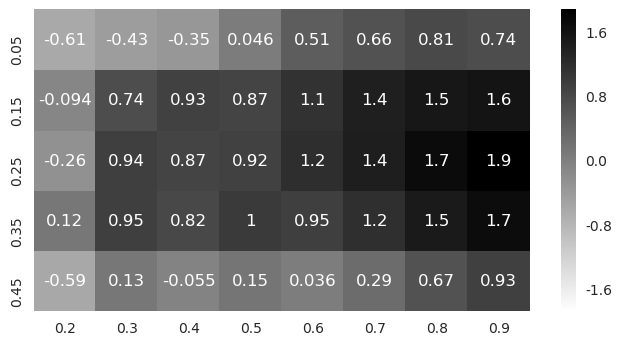

In [48]:
#x='k_tp'
#y='k_sl'
fig1, ax1 = plt.subplots(figsize = (8,4))
ax1 = sns.heatmap(hmapl1, annot=True, cmap = 'binary', 
            xticklabels=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], yticklabels=[0.05, 0.15, 0.25, 0.35, 0.45])
plt.show()

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


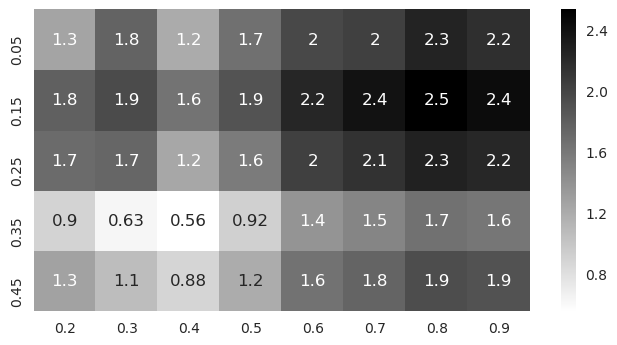

In [49]:
#x='k_tp'
#y='k_sl'
fig2, ax2 = plt.subplots(figsize = (8,4))
ax2 = sns.heatmap(hmapl2, annot=True, cmap = 'binary', 
            xticklabels=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], yticklabels=[0.05, 0.15, 0.25, 0.35, 0.45])
plt.show()

第一个热图最优的参数是(0.25,0.9)，参数高原在右侧，第二个热图是(0.15,0.8)，参数高原在右上侧。

其表现的思想为，即尽量大的止盈和尽量小的止损，这在牛市当中确实是一个很好的策略。

相比之下我更喜欢第二个图，因为第一个图y轴上下都有一个很大的台阶，而第二个高原的八个方向都露了出来，看起来更平滑一点。

关于如何避免过拟合、参数如何选取，需要进行进一步研究，这里就先假设结果可接受，取一个次优的参数(0.15,0.7)作为进一步研究。

空头策略相比多头策略的分析略有不同。

如果放弃空头策略，显然有lookback的嫌疑，当市场趋势不断变化时，多空策略产生的对冲才能使总体表现趋向稳定。

不过策略组的sharpe太低，只能矮子里挑高个了。

(range2,range3)的组合里，ssharpe大于0的只有8个，harpe前列的range_k和k_sl都很小，因此导致交易次数大增，交易次数越多对滑点的要求越严格，其他绩效数据也是惨不忍睹，这个组合并没有得出太好的结果。

来看看(range1,range2)的组合，虽然sharpe也很惨淡，不过交易次数不多，其他绩效指标都可接受，前列里range_k取0.2的出现次数较多，取出切片作分析。

In [50]:
df_s1_s = df_s1[df_s1['_para_range_k'] == 0.2].sort_values(by=['_para_k_sl', '_para_k_tp'], ascending=True)

In [51]:
hmaps1 = []
k = []
for index, row in df_s1_s.iterrows():
    k.append(row['sharpe'])
    if len(k) == 8:
        hmaps1.append(k)
        k = []

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


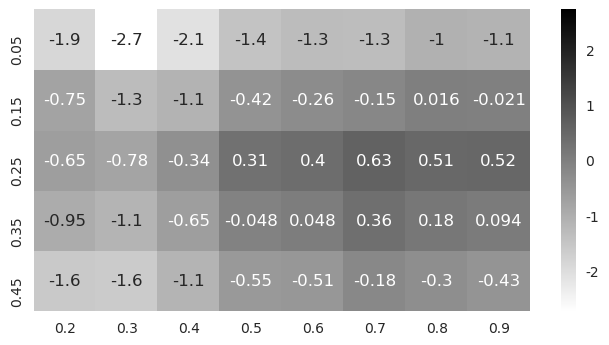

In [52]:
#x='k_tp'
#y='k_sl'
fig3, ax3 = plt.subplots(figsize = (8,4))
ax3 = sns.heatmap(hmaps1, annot=True, cmap = 'binary',
            xticklabels=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], yticklabels=[0.05, 0.15, 0.25, 0.35, 0.45])
plt.show()

可以看到不太明显的参数高原，不过y轴上有两个大台阶，最好的参数是(0.25, 0.7)。

关于参数的选择，还有更多可以探讨的地方，比如除了sharpe之外其他绩效指标的分析等。

而且如果参数的步长更小、范围更大，也可以获得更好的分析结果，但第三方平台性能有限，这也说明了建立本地回测引擎的重要性。

这里假设可以接受这些结果，来进行进一步验证。

#### 接下来需要做统计上的假设检验，来验证策略的可靠性。

在上面的分析里，我们先验地认为策略的回报应该是与策略本身有关。

然而期货市场是一个信噪比极低的市场，因此我们的策略也只有一点点的预测能力。

而我们的样本量又不足，因此我们也很有可能是幸运地得到好的回报而已。

因此，在进行下一步之前，有必要对先前获得的样本进行一次显著性的假设检验。

假设回报率的时间序列为R，策略发出信号的时间序列为S，市场的噪音为$\nu$。

有R = $\lambda$S + $\nu$，其中$\nu$应该服从正态分布或T分布。

我们希望R和S的相关性是显著的，否则有R = $\nu$，即策略回报完全是由随机的噪音所造成。

下面进行单样本的假设检验：

零假设：corr(R, S) ~ 0

通过10000次蒙地卡罗模拟，得出R和$\nu$相关性的t分布。

如果corr(R, S)在p_value=0.05的置信区间外，则推翻零假设。

否则不能推翻零假设，我们认为S和噪音$\nu$无异。

In [59]:
df_test = pd.read_csv('test1.csv',index_col=0)

In [60]:
df_test['return'] = df_test['value'].diff(1)/df_test['value']
df_test = df_test[1:].copy()
len(df_test)

5509

进行10000次蒙地卡罗模拟，获得R与$\nu$相关性的t分布

In [61]:
correlations = []
r = df_test['return'].tolist()
for i in range(10000):
    n = np.random.normal(0,1,5509)
    df_sim = pd.DataFrame(data = {'return': r, 'n': n})
    correlations.append(df_sim.corr('spearman').iloc[0,1])

corr(R, n)的分布如下

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


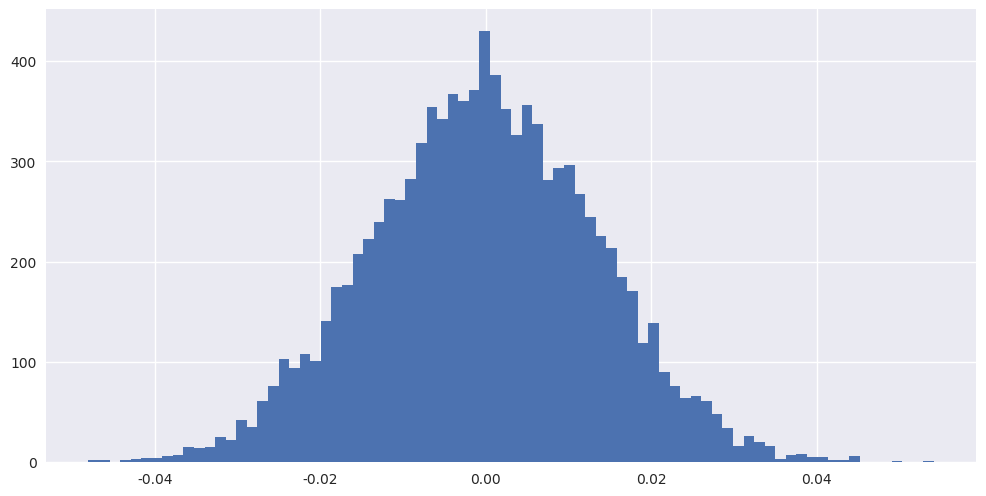

In [62]:
plt.hist(correlations, bins=80)
plt.show()

In [63]:
df_corr = pd.DataFrame({'corr':correlations}).sort_values(by='corr')
df_corr.iloc[250,0],df_corr.iloc[9750,0]

(-0.026531363905630042, 0.026284780517184681)

零假设的置信区间为(-0.026,0.026)

In [64]:
df_test.corr('spearman').iloc[1:,1:]

,signal,return
signal,1.00000,0.07718
return,0.07718,1.00000


corr(R, S)落在置信区间外，因此我们拒绝零假设，我们认为策略发出的信号S与回报率R之间的相关性比较显著。

### 回测验证样本


在确认了参数，可以在验证样本里看看表现如何。

目前多头策略的选择是buy_condition: range2, CI_condition: range3, range_k = 0.15, k_sl = 0.15, k_tp = 0.8

空头策略的选择是sell_condition: range1, CI_condition: range2, range_k = 0.2, k_sl = 0.25, k_tp = 0.7

下面看看ricequant上的可视化报告

![](http://chuantu.biz/t6/311/1526404851x-1566688760.png)

多头策略在验证样本里表现大幅下滑，sharpe变得惨不忍睹，甚至max_drawdown都大于return了，可以认为参数有过拟合了。

![](http://chuantu.biz/t6/311/1526410517x-1566688760.png)

空头策略的表现发挥稳定，return保持了差不多的水平，虽然sharpe比回测样本里也下降了，不过max_drawdown也同样下降了。

把多空策略复合在一起看看表现，策略其他不变，不过把账户提高到20w，保持10w做1手的杠杆比例。

![](http://chuantu.biz/t6/311/1526410808x-1566688760.png)

由于多头策略的拖累，sharpe依然惨不忍睹，不过提高杠杆可以是提高sharpe的。

而max_drawdown和return的比率保持在1:3以下，这个结果倒算满意。胜率ricequant里没统计，我自己计算是49.5%。

如果把杠杆调到1:1，以当前价格3600为计算，10w做2.8手的比例，多空最少各一手的话，账户最少需要设置7.2w。

sharpe都有一定提高，不过依然小于1。

![](http://chuantu.biz/t6/311/1526412824x-1566688760.png)

接下来，我们就要决定是否接受这一策略。

如果不接受，是继续做参数训练，还是把策略推广到其他周期、其他品种，亦或是进行策略逻辑的改进，这是后话了。

### 总结与展望

量化研究需要做的工作很多，本报告只是提供了其中一小部分工作的个人见解，作为量化领域的初学者，不足之处敬请多多批评。

后面需要完善的工作很多，横向需要做的是对多品种、多周期、多策略的研究。

纵向需要完善买卖逻辑，报单逻辑等，以使回测环境和模拟环境尽量贴近实盘。

因此对我而言目前最需要的是搭建线下研究平台，以提高研究效率。

其次是关于统计分析的进一步学习，以及策略思路的搜集，利用高效的研究平台可以快速筛选出有效的策略作进一步研究。

最后，除了cta策略，如能够把思路延伸到统计套利、多因子研究、机器学习等领域，也是大有帮助。